# JUPYTER_NOTEBOOK_OPENGL_v10_synth_blur_variety_backs_7x7

# Entrenamiento con datos sintéticos con Gaussian Blur de la red Mask R-CNN para segmentación

### Importar bibliotecas de detectron2, opencv, os, matplotlib y random:

In [1]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import get_detection_dataset_dicts
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from matplotlib import pyplot as plt
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os
import cv2
import random

### Registrar el dataset de entrenamiento, con su archivo .json y el nombre de la carpeta de las imágenes:

In [2]:
register_coco_instances("UCSP Fondecyt Dataset train", {}, "coco_dataset_train.json", "blurred_images")

### Mostrar 3 imágenes aleatorias del conjunto de entrenamiento, junto con sus etiquetas:

blurred_images\pieza0/img7_background79.png
blurred_images\pieza2/img9_background51.png
blurred_images\pieza2/img5_background7.png


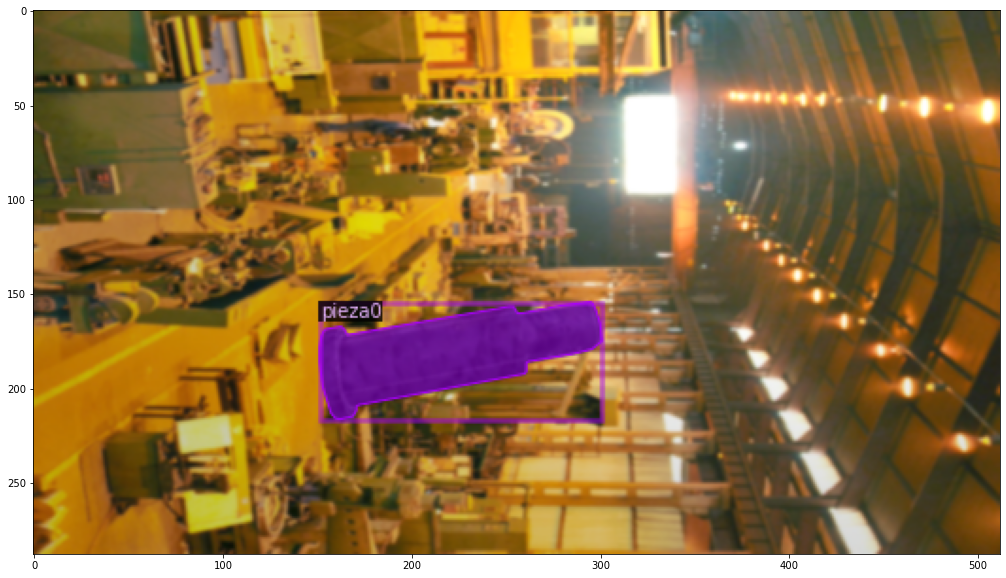

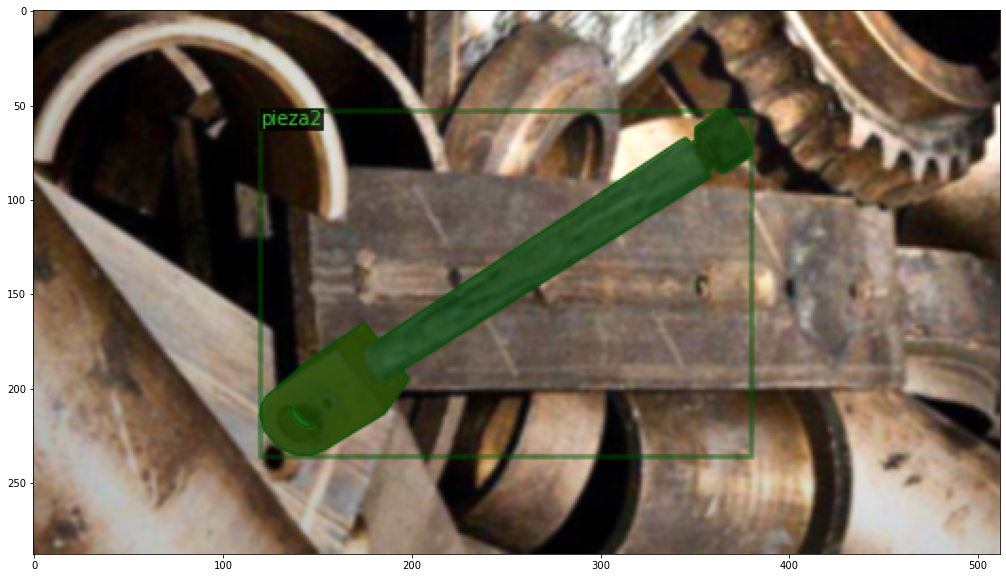

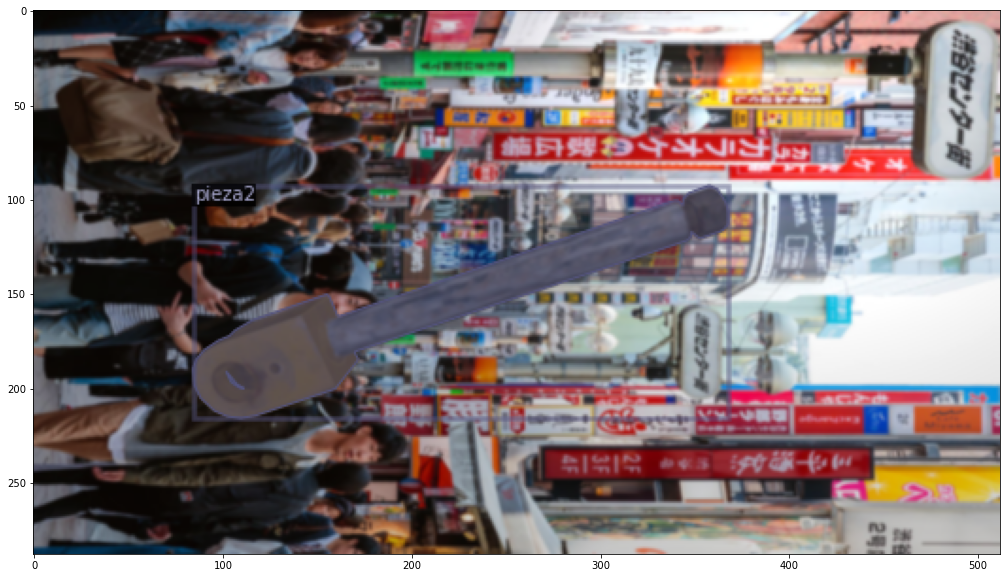

In [3]:
%matplotlib inline
dataset_dicts = get_detection_dataset_dicts(["UCSP Fondecyt Dataset train"])
dataset_metadata = MetadataCatalog.get("UCSP Fondecyt Dataset train")
for d in random.sample(dataset_dicts, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    #print(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(20,10))
    #plt.figure()
    plt.imshow(vis.get_image());
    

### Obtener un archivo de configuración y asignarle las configuraciones de nuestro modelo:

In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("UCSP Fondecyt Dataset train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 3
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 4000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class (ballon)

### Crear una carpeta para guardar los pesos entrenados y los resultados de las pruebas, además crear un "trainer":

In [5]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 

[09/16 00:23:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[09/16 00:23:04 d2.data.datasets.coco]: Loaded 3069 images in COCO format from coco_dataset_train.json
[09/16 00:23:04 d2.data.build]: Removed 0 images with no usable annotations. 3069 images left.
[09/16 00:23:04 d2.data.common]: Serializing 3069 elements to byte tensors and concatenating them all ...
[09/16 00:23:04 d2.data.common]: Serialized dataset takes 2.47 MiB
[09/16 00:23:04 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/16 00:23:04 d2.data.build]: Using training sampler TrainingSampler


### Cargar pesos de la red neuronal si es que ya se ha entrenado:

In [6]:
trainer.resume_or_load(resume=False)

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (3,) in the model!


### Entrenar el modelo de red neuronal:

In [7]:
trainer.train()

[09/16 00:23:04 d2.engine.train_loop]: Starting training from iteration 0
[09/16 00:23:23 d2.utils.events]:  eta: 0:51:10  iter: 19  total_loss: 2.442  loss_cls: 1.299  loss_box_reg: 0.416  loss_mask: 0.693  loss_rpn_cls: 0.011  loss_rpn_loc: 0.007  time: 0.7645  data_time: 0.1095  lr: 0.000005  max_mem: 3450M
[09/16 00:23:39 d2.utils.events]:  eta: 0:51:16  iter: 39  total_loss: 2.355  loss_cls: 1.202  loss_box_reg: 0.440  loss_mask: 0.686  loss_rpn_cls: 0.010  loss_rpn_loc: 0.008  time: 0.7711  data_time: 0.0020  lr: 0.000010  max_mem: 3450M
[09/16 00:23:54 d2.utils.events]:  eta: 0:50:50  iter: 59  total_loss: 2.230  loss_cls: 1.031  loss_box_reg: 0.449  loss_mask: 0.673  loss_rpn_cls: 0.015  loss_rpn_loc: 0.011  time: 0.7664  data_time: 0.0020  lr: 0.000015  max_mem: 3450M
[09/16 00:24:09 d2.utils.events]:  eta: 0:50:34  iter: 79  total_loss: 1.982  loss_cls: 0.830  loss_box_reg: 0.460  loss_mask: 0.651  loss_rpn_cls: 0.014  loss_rpn_loc: 0.008  time: 0.7619  data_time: 0.0020  lr:

[09/16 00:31:50 d2.utils.events]:  eta: 0:43:02  iter: 679  total_loss: 0.312  loss_cls: 0.069  loss_box_reg: 0.181  loss_mask: 0.057  loss_rpn_cls: 0.000  loss_rpn_loc: 0.008  time: 0.7664  data_time: 0.0021  lr: 0.000170  max_mem: 3450M
[09/16 00:32:06 d2.utils.events]:  eta: 0:42:48  iter: 699  total_loss: 0.320  loss_cls: 0.072  loss_box_reg: 0.181  loss_mask: 0.045  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  time: 0.7670  data_time: 0.0020  lr: 0.000175  max_mem: 3450M
[09/16 00:32:22 d2.utils.events]:  eta: 0:42:33  iter: 719  total_loss: 0.308  loss_cls: 0.064  loss_box_reg: 0.173  loss_mask: 0.053  loss_rpn_cls: 0.000  loss_rpn_loc: 0.008  time: 0.7671  data_time: 0.0020  lr: 0.000180  max_mem: 3450M
[09/16 00:32:37 d2.utils.events]:  eta: 0:42:17  iter: 739  total_loss: 0.321  loss_cls: 0.068  loss_box_reg: 0.177  loss_mask: 0.053  loss_rpn_cls: 0.000  loss_rpn_loc: 0.007  time: 0.7669  data_time: 0.0019  lr: 0.000185  max_mem: 3450M
[09/16 00:32:52 d2.utils.events]:  eta: 0:42

[09/16 00:40:22 d2.utils.events]:  eta: 0:34:53  iter: 1339  total_loss: 0.178  loss_cls: 0.034  loss_box_reg: 0.105  loss_mask: 0.038  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  time: 0.7701  data_time: 0.0020  lr: 0.000250  max_mem: 3450M
[09/16 00:40:38 d2.utils.events]:  eta: 0:34:38  iter: 1359  total_loss: 0.212  loss_cls: 0.037  loss_box_reg: 0.122  loss_mask: 0.040  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.7701  data_time: 0.0020  lr: 0.000250  max_mem: 3450M
[09/16 00:40:53 d2.utils.events]:  eta: 0:34:20  iter: 1379  total_loss: 0.206  loss_cls: 0.037  loss_box_reg: 0.122  loss_mask: 0.043  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  time: 0.7700  data_time: 0.0019  lr: 0.000250  max_mem: 3450M
[09/16 00:41:09 d2.utils.events]:  eta: 0:34:07  iter: 1399  total_loss: 0.199  loss_cls: 0.037  loss_box_reg: 0.113  loss_mask: 0.040  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.7703  data_time: 0.0020  lr: 0.000250  max_mem: 3450M
[09/16 00:41:24 d2.utils.events]:  eta: 

[09/16 00:48:54 d2.utils.events]:  eta: 0:26:14  iter: 1999  total_loss: 0.163  loss_cls: 0.028  loss_box_reg: 0.101  loss_mask: 0.036  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.7711  data_time: 0.0020  lr: 0.000250  max_mem: 3450M
[09/16 00:49:10 d2.utils.events]:  eta: 0:25:59  iter: 2019  total_loss: 0.169  loss_cls: 0.032  loss_box_reg: 0.092  loss_mask: 0.034  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.7713  data_time: 0.0020  lr: 0.000250  max_mem: 3450M
[09/16 00:49:25 d2.utils.events]:  eta: 0:25:43  iter: 2039  total_loss: 0.162  loss_cls: 0.028  loss_box_reg: 0.099  loss_mask: 0.037  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.7713  data_time: 0.0020  lr: 0.000250  max_mem: 3450M
[09/16 00:49:41 d2.utils.events]:  eta: 0:25:27  iter: 2059  total_loss: 0.162  loss_cls: 0.030  loss_box_reg: 0.096  loss_mask: 0.032  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  time: 0.7712  data_time: 0.0020  lr: 0.000250  max_mem: 3450M
[09/16 00:49:56 d2.utils.events]:  eta: 

[09/16 00:57:27 d2.utils.events]:  eta: 0:17:36  iter: 2659  total_loss: 0.169  loss_cls: 0.029  loss_box_reg: 0.096  loss_mask: 0.032  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  time: 0.7720  data_time: 0.0021  lr: 0.000250  max_mem: 3450M
[09/16 00:57:42 d2.utils.events]:  eta: 0:17:21  iter: 2679  total_loss: 0.139  loss_cls: 0.026  loss_box_reg: 0.072  loss_mask: 0.030  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  time: 0.7720  data_time: 0.0020  lr: 0.000250  max_mem: 3450M
[09/16 00:57:58 d2.utils.events]:  eta: 0:17:05  iter: 2699  total_loss: 0.149  loss_cls: 0.022  loss_box_reg: 0.080  loss_mask: 0.034  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  time: 0.7720  data_time: 0.0020  lr: 0.000250  max_mem: 3450M
[09/16 00:58:14 d2.utils.events]:  eta: 0:16:49  iter: 2719  total_loss: 0.150  loss_cls: 0.028  loss_box_reg: 0.084  loss_mask: 0.033  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.7721  data_time: 0.0020  lr: 0.000250  max_mem: 3450M
[09/16 00:58:29 d2.utils.events]:  eta: 

[09/16 01:05:59 d2.utils.events]:  eta: 0:08:57  iter: 3319  total_loss: 0.131  loss_cls: 0.023  loss_box_reg: 0.077  loss_mask: 0.028  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.7724  data_time: 0.0020  lr: 0.000250  max_mem: 3450M
[09/16 01:06:15 d2.utils.events]:  eta: 0:08:41  iter: 3339  total_loss: 0.141  loss_cls: 0.026  loss_box_reg: 0.083  loss_mask: 0.032  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.7725  data_time: 0.0019  lr: 0.000250  max_mem: 3450M
[09/16 01:06:31 d2.utils.events]:  eta: 0:08:25  iter: 3359  total_loss: 0.129  loss_cls: 0.022  loss_box_reg: 0.074  loss_mask: 0.028  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.7726  data_time: 0.0020  lr: 0.000250  max_mem: 3450M
[09/16 01:06:46 d2.utils.events]:  eta: 0:08:09  iter: 3379  total_loss: 0.126  loss_cls: 0.023  loss_box_reg: 0.070  loss_mask: 0.029  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  time: 0.7727  data_time: 0.0020  lr: 0.000250  max_mem: 3450M
[09/16 01:07:02 d2.utils.events]:  eta: 

[09/16 01:14:31 d2.utils.events]:  eta: 0:00:16  iter: 3979  total_loss: 0.125  loss_cls: 0.021  loss_box_reg: 0.067  loss_mask: 0.028  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.7726  data_time: 0.0020  lr: 0.000250  max_mem: 3450M
[09/16 01:14:47 d2.utils.events]:  eta: 0:00:00  iter: 3999  total_loss: 0.131  loss_cls: 0.026  loss_box_reg: 0.075  loss_mask: 0.029  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  time: 0.7725  data_time: 0.0021  lr: 0.000250  max_mem: 3450M
[09/16 01:14:47 d2.engine.hooks]: Overall training speed: 3997 iterations in 0:51:28 (0.7727 s / it)
[09/16 01:14:47 d2.engine.hooks]: Total training time: 0:51:37 (0:00:09 on hooks)


### Cargar extensión "tensorboard" y ejecutarla en la carpeta llamada "output":

In [1]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6006 (pid 14080), started 0:30:07 ago. (Use '!kill 14080' to kill it.)